## Proses Instalasi

In [ ]:
! pip install pandas==0.23.4
! pip install keras==2.3.1
! pip install termcolor==1.1.0
! pip install six==1.16.0
! pip install tensorflow==1.13.1
! pip install numpy==1.16.2
! pip install matplotlib==2.2.4
! pip install scikit-learn==0.24.2
! pip install h5py==2.10.0
! pip install git+https://www.github.com/keras-team/keras-contrib.git

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Memuat Library

In [2]:
import sys
import os
import json
import numpy as np

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Dense
from keras.layers import GRU, LSTM, Bidirectional
from keras.layers import Embedding, TimeDistributed, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras_contrib.layers.crf import CRF

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from operator import itemgetter

Using TensorFlow backend.


## Prapemrosesan Data

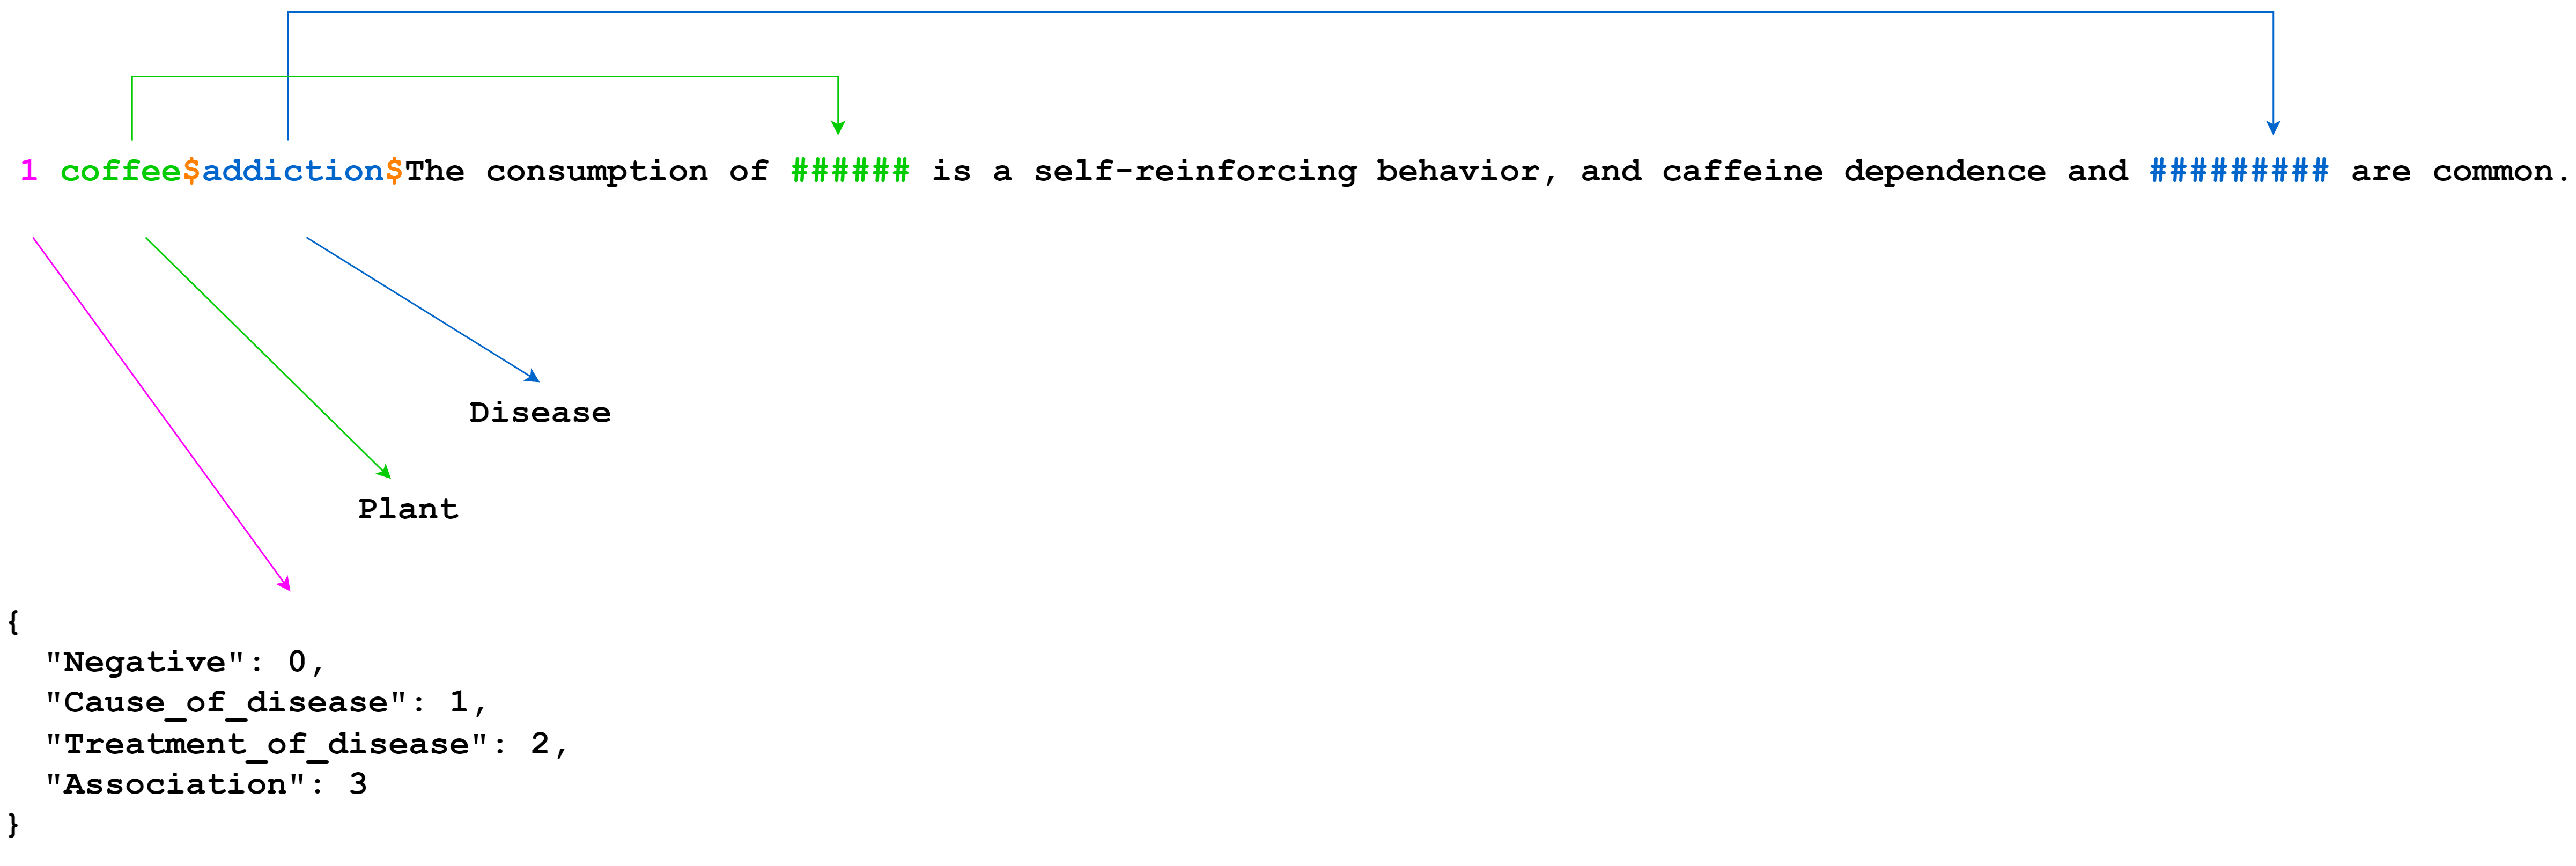

In [3]:
from IPython import display
display.Image("XtoT.png")

In [3]:
py_file_location = ""
sys.path.append(os.path.abspath(py_file_location))

In [4]:
from utils.load_data import get_train_test_pd
from utils.extract_feature import BertVector
from utils.att import Attention
from utils.crf import CRF
from sklearn.model_selection import train_test_split

# Train

### Encoding Undersampling

In [5]:
from imblearn.under_sampling import RandomUnderSampler

# Load data using get_train_test_pd() function
train_df, test_df = get_train_test_pd()

# Undersample the majority class
rus = RandomUnderSampler(random_state=42)
train_df, train_labels = rus.fit_resample(train_df[['text']], train_df['label'])

# Initialize BERT model
bert_model = BertVector(pooling_strategy="NONE", max_seq_len=256)

# Define function for encoding text using BERT model
def encode_text(text):
    return bert_model.encode([text])["encodes"][0]

# Encode text data for train and test sets
train_data = [encode_text(text) for text in train_df['text'].values]
test_data = [encode_text(text) for text in test_df['text'].values]

# Split train and test sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Convert data to numpy arrays
train_data = np.array(train_data)
val_data = np.array(val_data)
test_data = np.array(test_data)


# Print shapes of train and test sets
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Val data shape: {val_data.shape}, Val labels shape: {val_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_df['label'].shape}")


I:PROCESS:[graph:opt: 49]:model config: /Users/slametriyanto/Documents/MyApp/Dissertation_Project/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:PROCESS:[graph:opt: 55]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:PROCESS:[graph:opt:132]:load parameters from checkpoint...
I:PROCESS:[graph:opt:134]:freeze...
I:PROCESS:[graph:opt:137]:optimize...
I:PROCESS:[graph:opt:148]:write graph to a tmp file: tmp_graph21


Train data shape: (83, 256, 768), Train labels shape: (83,)
Val data shape: (21, 256, 768), Val labels shape: (21,)
Test data shape: (261, 256, 768), Test labels shape: (261,)


In [21]:
# Print shapes of train and test sets
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Val data shape: {val_data.shape}, Val labels shape: {val_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_df['label'].shape}")

Train data shape: (104,), Train labels shape: (83,)
Val data shape: (261,), Val labels shape: (21,)
Test data shape: (261, 256, 768), Test labels shape: (261,)


In [9]:
#train_data, val_data, train_labels, val_labels 

x_train = train_data
x_test = val_data
y_train = train_labels
y_test = val_labels

### Training and Test Set

In [10]:
num_classes = 4 # {cause of disease, treatment of disease, association, negative}

In [11]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [12]:
print("Size of training input data : ", x_train.shape)
print("Size of training output data : ", y_train.shape)
print("Size of testing input data : ", x_test.shape)
print("Size of testing output data : ", y_test.shape)

Size of training input data :  (83, 256, 768)
Size of training output data :  (83, 4)
Size of testing input data :  (21, 256, 768)
Size of testing output data :  (21, 4)


## Model Config

In [38]:
inputs = Input(name="Input", shape=(256, 768, ))
bilstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True, name="Long-Short-Term-Memory"), name="Bidirectional")(inputs)
crf = CRF(num_classes, name="Conditional-Random-Field")(bilstm)
dense = Dense(num_classes, activation='softmax', name="Output")(crf)

model = Model(inputs, dense, name="Relation-Extraction-BiLSTM-CRF")

In [39]:
# If there are .hdf5 files in the original models folder, delete them all
model_dir = 'output-under/e40-dr03-b64-1'
if os.listdir(model_dir):
    for file in os.listdir(model_dir):
        os.remove(os.path.join(model_dir, file))

## Model Visualization

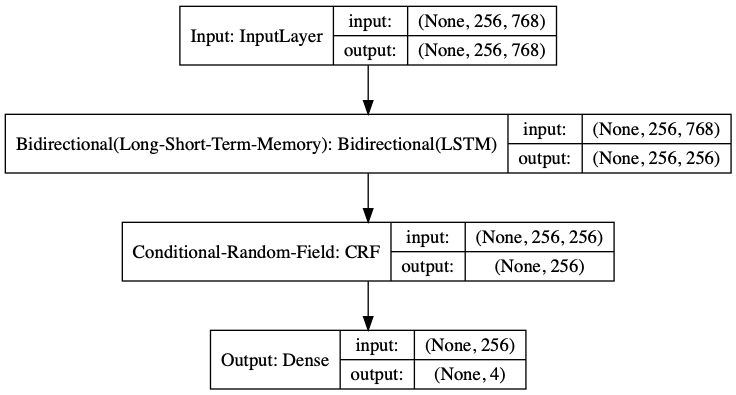

In [40]:
plot_model(model, to_file='model.png', show_shapes=True)

# Model Process

In [41]:
model.summary()

Model: "Relation-Extraction-BiLSTM-CRF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 256, 768)          0         
_________________________________________________________________
Bidirectional (Bidirectional (None, 256, 256)          918528    
_________________________________________________________________
Conditional-Random-Field (CR (None, 256)               1284      
_________________________________________________________________
Output (Dense)               (None, 4)                 1028      
Total params: 920,840
Trainable params: 920,840
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [27]:
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

# Uji 1

In [43]:
# Save the latest val_acc best model file
filepath="output-under/e40-dr03-b64-256/e-{epoch:02d}-los-{val_loss:.4f}-acc-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [44]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=64, 
    epochs=40, 
    callbacks=[checkpoint]) 
    #callbacks=[early_stopping, checkpoint])

Train on 83 samples, validate on 21 samples
Epoch 1/40
83/83 [==============================] - 2s 30ms/step - loss: 1.3919 - accuracy: 0.2771 - val_loss: 1.3924 - val_accuracy: 0.2381

Epoch 00001: val_accuracy improved from -inf to 0.23810, saving model to output-under/e40-dr03-b64-1/per-rel-01-0.2381.hdf5
Epoch 2/40
83/83 [==============================] - 2s 18ms/step - loss: 1.3493 - accuracy: 0.3253 - val_loss: 1.4264 - val_accuracy: 0.1905

Epoch 00002: val_accuracy did not improve from 0.23810
Epoch 3/40
83/83 [==============================] - 2s 18ms/step - loss: 1.3524 - accuracy: 0.3133 - val_loss: 1.3596 - val_accuracy: 0.3333

Epoch 00003: val_accuracy improved from 0.23810 to 0.33333, saving model to output-under/e40-dr03-b64-1/per-rel-03-0.3333.hdf5
Epoch 4/40
83/83 [==============================] - 2s 19ms/step - loss: 1.3338 - accuracy: 0.3494 - val_loss: 1.3153 - val_accuracy: 0.4286

Epoch 00004: val_accuracy improved from 0.33333 to 0.42857, saving model to output

83/83 [==============================] - 2s 20ms/step - loss: 0.0482 - accuracy: 0.9880 - val_loss: 0.7203 - val_accuracy: 0.7143

Epoch 00039: val_accuracy did not improve from 0.80952
Epoch 40/40
83/83 [==============================] - 2s 21ms/step - loss: 0.0453 - accuracy: 1.0000 - val_loss: 0.7133 - val_accuracy: 0.7143

Epoch 00040: val_accuracy did not improve from 0.80952


In [45]:
print('The effect on the test set：', model.evaluate(x_test, y_test))

21/21 [==============================] - 0s 9ms/step
The effect on the test set： [0.7133297920227051, 0.7142857313156128]


# Uji Skema 1

In [47]:
with open('input/rel_dict.json', 'r', encoding='utf-8') as f:
    label_id_dict = json.loads(f.read())

sorted_label_id_dict = sorted(label_id_dict.items(), key=itemgetter(1))
values = [_[0] for _ in sorted_label_id_dict]

In [49]:
model = load_model(
  "output-under/e40-dr03-b64-256/per-rel-26-0.8095.hdf5", 
  custom_objects={"CRF": CRF})

y_pred = model.predict(x_test, batch_size=8)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.80      0.80      0.80         5
    Cause_of_disease       0.62      0.83      0.71         6
Treatment_of_disease       1.00      0.50      0.67         4
         Association       1.00      1.00      1.00         6

            accuracy                           0.81        21
           macro avg       0.86      0.78      0.80        21
        weighted avg       0.85      0.81      0.81        21



dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


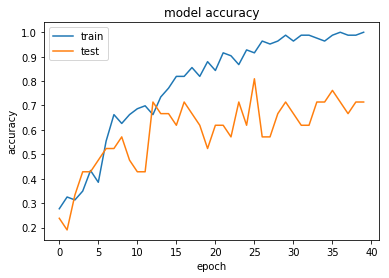

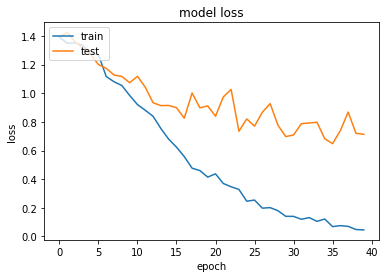

In [50]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

    val_loss  val_accuracy      loss  accuracy
0   1.392438      0.238095  1.391893  0.277108
1   1.426350      0.190476  1.349344  0.325301
2   1.359643      0.333333  1.352429  0.313253
3   1.315261      0.428571  1.333789  0.349398
4   1.270229      0.428571  1.275773  0.433735
5   1.200688      0.476190  1.269480  0.385542
6   1.174061      0.523810  1.116928  0.554217
7   1.127793      0.523810  1.080215  0.662651
8   1.117574      0.571429  1.054258  0.626506
9   1.073871      0.476190  0.984627  0.662651
10  1.118307      0.428571  0.920952  0.686747
11  1.042626      0.428571  0.881407  0.698795
12  0.933870      0.714286  0.839380  0.662651
13  0.913597      0.666667  0.753750  0.734940
14  0.914971      0.666667  0.679411  0.771084
15  0.899131      0.619048  0.623726  0.819277
16  0.825904      0.714286  0.557340  0.819277
17  1.002090      0.666667  0.476646  0.855422
18  0.898390      0.619048  0.460005  0.819277
19  0.911821      0.523810  0.414178  0.879518
20  0.839716 

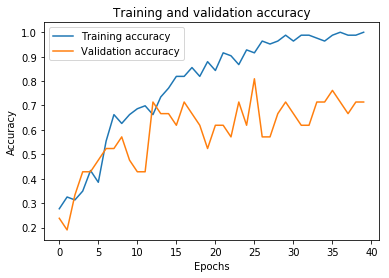

In [52]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict

In [51]:
! python model_predict.py

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
2022-09-16 16:52:46.710520: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Instructions for updating:
Use tf.cast instead.
tobacco$lung cancer$In conclusion, variation in ########### rates between populations may be due to: (1) differences in effective exposure to ####### smoke carcinogens; (2) differences in factors which modify the effect of ####### smoke, including differences in host susceptibility and metabolism of carcinogens, or (3) differences in exposure to other independent risk factors for ###########.
I:BERT_VEC:[graph:opt: 48]:model config: /Users/slametriyanto/Documents/MyApp/Dissertation_Project/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:BERT_VEC:[graph:opt: 54]:build graph...

For more information, please see:
  * https://github.com/tensorflow/community/blob/